In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import tensorflow as tf
import time
from datetime import datetime

NUM_DIMENSIONS = 3
NUM_DIHEDRALS = 3

In [24]:
def drmsd(u, v, weights, name=None):
    """ Computes the dRMSD of two tensors of vectors.
        Vectors are assumed to be in the third dimension. Op is done element-wise over batch.
    Args:
        u, v:    [NUM_STEPS, BATCH_SIZE, NUM_DIMENSIONS]
        weights: [NUM_STEPS, NUM_STEPS, BATCH_SIZE]
    Returns:
                 [BATCH_SIZE]
    """

    with tf.name_scope(name, 'dRMSD', [u, v, weights]) as scope:
        u = tf.convert_to_tensor(u, name='u')
        v = tf.convert_to_tensor(v, name='v')
        weights = tf.convert_to_tensor(weights, name='weights')

        diffs = pairwise_distance(u) - pairwise_distance(v)                                  # [NUM_STEPS, NUM_STEPS, BATCH_SIZE]
        norms = reduce_l2_norm(diffs, reduction_indices=[0, 1], weights=weights, name=scope) # [BATCH_SIZE]

        return norms

def pairwise_distance(u, name=None):
    """ Computes the pairwise distance (l2 norm) between all vectors in the tensor.
        Vectors are assumed to be in the third dimension. Op is done element-wise over batch.
    Args:
        u: [NUM_STEPS, BATCH_SIZE, NUM_DIMENSIONS]
    Returns:
           [NUM_STEPS, NUM_STEPS, BATCH_SIZE]
    """
    with tf.name_scope(name, 'pairwise_distance', [u]) as scope:
        u = tf.convert_to_tensor(u, name='u')
        
        diffs = u - tf.expand_dims(u, 1)                                 # [NUM_STEPS, NUM_STEPS, BATCH_SIZE, NUM_DIMENSIONS]
        norms = reduce_l2_norm(diffs, reduction_indices=[3], name=scope) # [NUM_STEPS, NUM_STEPS, BATCH_SIZE]

        return norms

def point_to_coordinate(pt, num_fragments=6, parallel_iterations=4, swap_memory=False, name=None):
    """ Takes points from dihedral_to_point and sequentially converts them into the coordinates of a 3D structure.
        Reconstruction is done in parallel, by independently reconstructing num_fragments fragments and then 
        reconstituting the chain at the end in reverse order. The core reconstruction algorithm is NeRF, based on 
        DOI: 10.1002/jcc.20237 by Parsons et al. 2005. The parallelized version is described in XXX.
    Args:
        pt: [NUM_STEPS x NUM_DIHEDRALS, BATCH_SIZE, NUM_DIMENSIONS]
    Opts:
        num_fragments: Number of fragments to reconstruct in parallel. If None, the number is chosen adaptively
    Returns:
            [NUM_STEPS x NUM_DIHEDRALS, BATCH_SIZE, NUM_DIMENSIONS] 
    """                             

    with tf.name_scope(name, 'point_to_coordinate', [pt]) as scope:
        pt = tf.convert_to_tensor(pt, name='pt')

        # compute optimal number of fragments if needed
        s = tf.shape(pt)[0] # NUM_STEPS x NUM_DIHEDRALS
        if num_fragments is None: num_fragments = tf.cast(tf.sqrt(tf.cast(s, dtype=tf.float32)), dtype=tf.int32)

        # initial three coordinates (specifically chosen to eliminate need for extraneous matmul)
        Triplet = collections.namedtuple('Triplet', 'a, b, c')
        batch_size = pt.get_shape().as_list()[1] # BATCH_SIZE
        init_mat = np.array([[-np.sqrt(1.0 / 2.0), np.sqrt(3.0 / 2.0), 0], [-np.sqrt(2.0), 0, 0], [0, 0, 0]], dtype='float32')
        init_coords = Triplet(*[tf.reshape(tf.tile(row[np.newaxis], tf.stack([num_fragments * batch_size, 1])), 
                                           [num_fragments, batch_size, NUM_DIMENSIONS]) for row in init_mat])
                      # NUM_DIHEDRALS x [NUM_FRAGS, BATCH_SIZE, NUM_DIMENSIONS] 
        
        # pad points to yield equal-sized fragments
        r = ((num_fragments - (s % num_fragments)) % num_fragments)          # (NUM_FRAGS x FRAG_SIZE) - (NUM_STEPS x NUM_DIHEDRALS)
        pt = tf.pad(pt, [[0, r], [0, 0], [0, 0]])                            # [NUM_FRAGS x FRAG_SIZE, BATCH_SIZE, NUM_DIMENSIONS]
        pt = tf.reshape(pt, [num_fragments, -1, batch_size, NUM_DIMENSIONS]) # [NUM_FRAGS, FRAG_SIZE,  BATCH_SIZE, NUM_DIMENSIONS]
        pt = tf.transpose(pt, perm=[1, 0, 2, 3])                             # [FRAG_SIZE, NUM_FRAGS,  BATCH_SIZE, NUM_DIMENSIONS]

        # extension function used for single atom reconstruction and whole fragment alignment
        def extend(tri, pt, multi_m):
            """
            Args:
                tri: NUM_DIHEDRALS x [NUM_FRAGS/0,         BATCH_SIZE, NUM_DIMENSIONS]
                pt:                  [NUM_FRAGS/FRAG_SIZE, BATCH_SIZE, NUM_DIMENSIONS]
                multi_m: bool indicating whether m (and tri) is higher rank. pt is always higher rank; what changes is what the first rank is.
            """

            bc = tf.nn.l2_normalize(tri.c - tri.b, -1, name='bc')                                        # [NUM_FRAGS/0, BATCH_SIZE, NUM_DIMS]        
            n = tf.nn.l2_normalize(tf.cross(tri.b - tri.a, bc), -1, name='n')                            # [NUM_FRAGS/0, BATCH_SIZE, NUM_DIMS]
            if multi_m: # multiple fragments, one atom at a time. 
                m = tf.transpose(tf.stack([bc, tf.cross(n, bc), n]), perm=[1, 2, 3, 0], name='m')        # [NUM_FRAGS,   BATCH_SIZE, NUM_DIMS, 3 TRANS]
            else: # single fragment, reconstructed entirely at once.
                s = tf.pad(tf.shape(pt), [[0, 1]], constant_values=3)                                    # FRAG_SIZE, BATCH_SIZE, NUM_DIMS, 3 TRANS
                m = tf.transpose(tf.stack([bc, tf.cross(n, bc), n]), perm=[1, 2, 0])                     # [BATCH_SIZE, NUM_DIMS, 3 TRANS]
                m = tf.reshape(tf.tile(m, [s[0], 1, 1]), s, name='m')                                    # [FRAG_SIZE, BATCH_SIZE, NUM_DIMS, 3 TRANS]
            coord = tf.add(tf.squeeze(tf.matmul(m, tf.expand_dims(pt, 3)), axis=3), tri.c, name='coord') # [NUM_FRAGS/FRAG_SIZE, BATCH_SIZE, NUM_DIMS]
            return coord
        
        # loop over FRAG_SIZE in NUM_FRAGS parallel fragments, sequentially generating the coordinates for each fragment across all batches
        i = tf.constant(0)
        s_padded = tf.shape(pt)[0] # FRAG_SIZE
        coords_ta = tf.TensorArray(tf.float32, size=s_padded, tensor_array_name='coordinates_array')
                    # FRAG_SIZE x [NUM_FRAGS, BATCH_SIZE, NUM_DIMENSIONS] 
        
        def loop_extend(i, tri, coords_ta): # FRAG_SIZE x [NUM_FRAGS, BATCH_SIZE, NUM_DIMENSIONS] 
            coord = extend(tri, pt[i], True)
            return [i + 1, Triplet(tri.b, tri.c, coord), coords_ta.write(i, coord)]

        _, tris, coords_pretrans_ta = tf.while_loop(lambda i, _1, _2: i < s_padded, loop_extend, [i, init_coords, coords_ta],
                                                    parallel_iterations=parallel_iterations, swap_memory=swap_memory)
                                      # NUM_DIHEDRALS x [NUM_FRAGS, BATCH_SIZE, NUM_DIMENSIONS], 
                                      # FRAG_SIZE x [NUM_FRAGS, BATCH_SIZE, NUM_DIMENSIONS] 
        
        # loop over NUM_FRAGS in reverse order, bringing all the downstream fragments in alignment with current fragment
        coords_pretrans = tf.transpose(coords_pretrans_ta.stack(), perm=[1, 0, 2, 3]) # [NUM_FRAGS, FRAG_SIZE, BATCH_SIZE, NUM_DIMENSIONS]
        i = tf.shape(coords_pretrans)[0] # NUM_FRAGS

        def loop_trans(i, coords):
            transformed_coords = extend(Triplet(*[di[i] for di in tris]), coords, False)
            return [i - 1, tf.concat([coords_pretrans[i], transformed_coords], 0)]

        _, coords_trans = tf.while_loop(lambda i, _: i > -1, loop_trans, [i - 2, coords_pretrans[-1]],
                                        parallel_iterations=parallel_iterations, swap_memory=swap_memory)
                          # [NUM_FRAGS x FRAG_SIZE, BATCH_SIZE, NUM_DIMENSIONS]

        # lose last atom and pad from the front to gain an atom ([0,0,0], consistent with init_mat), to maintain correct atom ordering
        coords = tf.pad(coords_trans[:s-1], [[1, 0], [0, 0], [0, 0]], name=scope) # [NUM_STEPS x NUM_DIHEDRALS, BATCH_SIZE, NUM_DIMENSIONS]

        return coords
    
def dihedral_to_point(dihedral, r=BOND_LENGTHS, theta=BOND_ANGLES, name=None):
    """ Takes triplets of dihedral angles (phi, psi, omega) and returns 3D points ready for use in
        reconstruction of coordinates. Bond lengths and angles are based on idealized averages.
    Args:
        dihedral: [NUM_STEPS, BATCH_SIZE, NUM_DIHEDRALS]
    Returns:
                  [NUM_STEPS x NUM_DIHEDRALS, BATCH_SIZE, NUM_DIMENSIONS]
    """

    with tf.name_scope(name, 'dihedral_to_point', [dihedral]) as scope:
        dihedral = tf.convert_to_tensor(dihedral, name='dihedral') # [NUM_STEPS, BATCH_SIZE, NUM_DIHEDRALS]

        num_steps  = tf.shape(dihedral)[0]
        batch_size = dihedral.get_shape().as_list()[1] # important to use get_shape() to keep batch_size fixed for performance reasons

        r_cos_theta = tf.constant(r * np.cos(np.pi - theta), name='r_cos_theta') # [NUM_DIHEDRALS]
        r_sin_theta = tf.constant(r * np.sin(np.pi - theta), name='r_sin_theta') # [NUM_DIHEDRALS]

        pt_x = tf.tile(tf.reshape(r_cos_theta, [1, 1, -1]), [num_steps, batch_size, 1], name='pt_x') # [NUM_STEPS, BATCH_SIZE, NUM_DIHEDRALS]
        pt_y = tf.multiply(tf.cos(dihedral), r_sin_theta,                               name='pt_y') # [NUM_STEPS, BATCH_SIZE, NUM_DIHEDRALS]
        pt_z = tf.multiply(tf.sin(dihedral), r_sin_theta,                               name='pt_z') # [NUM_STEPS, BATCH_SIZE, NUM_DIHEDRALS]

        pt = tf.stack([pt_x, pt_y, pt_z])                                                       # [NUM_DIMS, NUM_STEPS, BATCH_SIZE, NUM_DIHEDRALS]
        pt_perm = tf.transpose(pt, perm=[1, 3, 2, 0])                                           # [NUM_STEPS, NUM_DIHEDRALS, BATCH_SIZE, NUM_DIMS]
        pt_final = tf.reshape(pt_perm, [num_steps * NUM_DIHEDRALS, batch_size, NUM_DIMENSIONS], # [NUM_STEPS x NUM_DIHEDRALS, BATCH_SIZE, NUM_DIMS]
                              name=scope) 

        return pt_final
    
def _coordinates(dihedrals):
    """ Converts dihedrals into full 3D structures. """

    # converts dihedrals to points ready for reconstruction.
    points = dihedral_to_point(dihedrals) # [NUM_STEPS x NUM_DIHEDRALS, BATCH_SIZE, NUM_DIMENSIONS]
             
    # converts points to final 3D coordinates.
    coordinates = point_to_coordinate(points) 
                  # [NUM_STEPS x NUM_DIHEDRALS, BATCH_SIZE, NUM_DIMENSIONS]

    return coordinates

Parsing provided by AlQuraishi

In [25]:
NUM_AAS = 20
NUM_DIMENSIONS = 3

def masking_matrix(mask, name=None):
    """ Constructs a masking matrix to zero out pairwise distances due to missing residues or padding. 

    Args:
        mask: 0/1 vector indicating whether a position should be masked (0) or not (1)

    Returns:
        A square matrix with all 1s except for rows and cols whose corresponding indices in mask are set to 0.
        [MAX_SEQ_LENGTH, MAX_SEQ_LENGTH]
    """

    with tf.name_scope(name, 'masking_matrix', [mask]) as scope:
        mask = tf.convert_to_tensor(mask, name='mask')

        mask = tf.expand_dims(mask, 0)
        base = tf.ones([tf.size(mask), tf.size(mask)])
        matrix_mask = base * mask * tf.transpose(mask)

        return matrix_mask
        
def read_protein(filename_queue, max_length, num_evo_entries=21, name=None):
    """ Reads and parses a ProteinNet TF Record. 

        Primary sequences are mapped onto 20-dimensional one-hot vectors.
        Evolutionary sequences are mapped onto num_evo_entries-dimensional real-valued vectors.
        Secondary structures are mapped onto ints indicating one of 8 class labels.
        Tertiary coordinates are flattened so that there are 3 times as many coordinates as 
        residues.

        Evolutionary, secondary, and tertiary entries are optional.

    Args:
        filename_queue: TF queue for reading files
        max_length:     Maximum length of sequence (number of residues) [MAX_LENGTH]. Not a 
                        TF tensor and is thus a fixed value.

    Returns:
        id: string identifier of record
        one_hot_primary: AA sequence as one-hot vectors
        evolutionary: PSSM sequence as vectors
        secondary: DSSP sequence as int class labels
        tertiary: 3D coordinates of structure
        matrix_mask: Masking matrix to zero out pairwise distances in the masked regions
        pri_length: Length of amino acid sequence
        keep: True if primary length is less than or equal to max_length
    """

    with tf.name_scope(name, 'read_protein', []) as scope:
        reader = tf.TFRecordReader()
        _, serialized_example = reader.read(filename_queue)

        context, features = tf.parse_single_sequence_example(serialized_example,
                                context_features={'id': tf.FixedLenFeature((1,), tf.string)},
                                sequence_features={
                                    'primary':      tf.FixedLenSequenceFeature((1,),               tf.int64),
                                    'evolutionary': tf.FixedLenSequenceFeature((num_evo_entries,), tf.float32, allow_missing=True),
                                    'secondary':    tf.FixedLenSequenceFeature((1,),               tf.int64,   allow_missing=True),
                                    'tertiary':     tf.FixedLenSequenceFeature((NUM_DIMENSIONS,),  tf.float32, allow_missing=True),
                                    'mask':         tf.FixedLenSequenceFeature((1,),               tf.float32, allow_missing=True)})
        id_ = context['id'][0]
        primary =   tf.to_int32(features['primary'][:, 0])
        evolutionary =          features['evolutionary']
        secondary = tf.to_int32(features['secondary'][:, 0])
        tertiary =              features['tertiary']
        mask =                  features['mask'][:, 0]

        pri_length = tf.size(primary)
        
        keep = tf.ones_like(pri_length)
        if max_length:
            keep = pri_length <= max_length

        one_hot_primary = tf.one_hot(primary, NUM_AAS)

        # Generate tertiary masking matrix--if mask is missing then assume all residues are present
        mask = tf.cond(tf.not_equal(tf.size(mask), 0), lambda: mask, lambda: tf.ones([pri_length]))
        ter_mask = masking_matrix(mask, name='ter_mask')        

        return id_, one_hot_primary, evolutionary, secondary, tertiary, ter_mask, pri_length, keep

Definitions of how to calculate dihedral angles and set up a bidirecitonal lstm

In [26]:
def tf_rad2deg(rad):
    pi_on_180 = 0.017453292519943295
    return rad / pi_on_180

# takes a 4-dimensional tensor (N, K, 4, 3) and outputs (N, K, 3) angles
def dihedral_tf3(p):
    p0 = tf.gather(p, 0, axis=2)
    p1 = tf.gather(p, 1, axis=2)
    p2 = tf.gather(p, 2, axis=2)
    p3 = tf.gather(p, 3, axis=2)
    
    b0 = -1.0 * (tf.subtract(p1, p0))
    b1 = tf.subtract(p2, p1)
    b2 = tf.subtract(p3, p2)
    
    b1 = tf.divide(b1, tf.add(tf.norm(b1, axis=2, keepdims=True), tf.constant(1e-10)))
#     b1 = tf.where(tf.is_nan(b1), tf.ones_like(b1), b1) # what to do when norm is 0?
    
    v = tf.subtract(b0, tf.einsum('bi,bij->bij', tf.einsum('bij,bij->bi', b0, b1), b1))
    w = tf.subtract(b2, tf.einsum('bi,bij->bij', tf.einsum('bij,bij->bi', b2, b1), b1))
    
    x = tf.reduce_sum( tf.multiply( v, w ), 2, keepdims=True )
    y = tf.reduce_sum( tf.multiply( tf.cross(b1, v), w ), 2, keepdims=True )

#     return tf_rad2deg(tf.atan2(y,x))
    return tf.atan2(y,x)

# euclidean_coordinates are of shape (batch_size, protein_length, 3)
def dihedral_pipeline(euclidean_coordinates, batch_size, protein_length):
    # chooses all possible slices of length 4
    euclidean_coordinates = euclidean_coordinates[:,:,:,None]
    all_4_len_slices_euc_coord = tf.extract_image_patches(euclidean_coordinates,
      ksizes=[1, 4, 3, 1],
      strides=[1, 1, 1, 1],
      rates=[1, 1, 1, 1],
      padding='VALID')
    all_4_len_slices_euc_coord = tf.reshape(tf.squeeze(all_4_len_slices_euc_coord), [batch_size, -1, 4, 3])

    # calculates torsional angles on the entire batch
    dihedral_angles = dihedral_tf3(all_4_len_slices_euc_coord)

    # adds 3 zeros at the end because I can't calculate the angle of
    # the last 3 atmos (need at least 4 atoms to calculate an angle)
    padding = tf.constant([[0, 0], [0,3], [0,0]])
    dihedral_angles = tf.pad(dihedral_angles, padding)

    # reshaping the angles (because input is 3 times the length of normal protein)
    dihedral_angles_shape = tf.gather(tf.shape(dihedral_angles), [0,1])
    dihedral_angles = tf.reshape(dihedral_angles, shape=dihedral_angles_shape)
    return tf.reshape(dihedral_angles, shape=(tf.gather(dihedral_angles_shape, 0), protein_length, 3))
    
# helper for setting up the bidirectional, multilayer lstm
def bidirectional_lstm(input_data, num_layers, rnn_size, keep_prob, lengths):
    output = input_data
    for layer in range(num_layers):
        with tf.variable_scope('encoder_{}'.format(layer),reuse=tf.AUTO_REUSE):

            cell_fw = tf.contrib.rnn.LSTMCell(rnn_size, state_is_tuple = True)
            cell_fw = tf.contrib.rnn.DropoutWrapper(cell_fw, input_keep_prob = keep_prob)

            cell_bw = tf.contrib.rnn.LSTMCell(rnn_size, state_is_tuple = True)
            cell_bw = tf.contrib.rnn.DropoutWrapper(cell_bw, input_keep_prob = keep_prob)

            outputs, states = tf.nn.bidirectional_dynamic_rnn(cell_fw, 
                                                              cell_bw, 
                                                              output,
                                                              dtype=tf.float32,
                                                              sequence_length=lengths)
            output = tf.concat(outputs,2)

    return output

# helper to count number of records in a TF record file
def get_num_records(tf_record_file):
    return len([x for x in tf.python_io.tf_record_iterator(tf_record_file)])

Define and load training paths. Count the number of training samples.

In [27]:
# choose paths from which to get training data
percentages = [30, 50, 70, 90]
percentages = [50]
main_path = "../../Data/ProteinNet/casp7/training/"
paths = [main_path + str(perc) + '/*' for perc in percentages]
print(paths)
# load all the file names from these paths
base_names = [glob.glob(a_path) for a_path in paths]
base_names = list(np.concatenate(base_names))

training_samples = np.sum([get_num_records(file) for file in base_names])
training_samples

['../../Data/ProteinNet/casp7/training/50/*']


13024

Setting up the computational graph

In [29]:
tf.reset_default_graph()

# the input pipeline should be rewritten using
# the new dataset api that tesnorflow introduced

# parameters for the training and
# queues that control data flow from files
num_epochs = 100
batch_size=32
capacity=1000
min_after_dequeue=100
lstm_units = 500
lstm_layers = 2

limit_protein_size = None

# this queue is taking all the files and asynchronously
# passes them forward (so that the rest of the computational
# graph that actually does computation doesn't have to wait for new input)
file_queue = tf.train.string_input_producer(
    tf.convert_to_tensor(base_names),
    num_epochs=num_epochs,
    shuffle=True # not sure if this shuffle works
)

# the parsing that Al Quraishi provides to load the ProteinNet data
res = read_protein(file_queue, max_length=limit_protein_size)
# unpacking the result
id_, one_hot_primary, evolutionary, secondary, tertiary, ter_mask, pri_length, keep = res

## I couldn't make shuffle batch work
## because it doesn't have the dynamic padding included
## workaround: https://github.com/tensorflow/tensorflow/issues/5147#issuecomment-271086206
# ids, data, length = tf.train.shuffle_batch(
#       [id_, one_hot_primary, pri_length], 
#       batch_size=batch_size, 
#       capacity=capacity,
#       min_after_dequeue=min_after_dequeue)

# dynamic pad makes sure that the length of the proteins
# is padded to the longest protein in the batch
ids, one_hot_primary, evolutionary, labels, labels_mask, length, keep = tf.train.batch(
      [id_, one_hot_primary, evolutionary, tertiary, ter_mask, pri_length, keep], 
      batch_size=batch_size, 
      capacity=capacity, 
      dynamic_pad=True
    )

if limit_protein_size:
    ids = tf.boolean_mask(ids, keep, axis=0)
    one_hot_primary = tf.boolean_mask(one_hot_primary, keep, axis=0)
    evolutionary = tf.boolean_mask(evolutionary, keep, axis=0)
    labels = tf.boolean_mask(labels, keep, axis=0)
    labels_mask = tf.boolean_mask(labels_mask, keep, axis=0)
    length = tf.boolean_mask(length, keep, axis=0)

# refresh the batch_size because the keep mask could have
# made it smaller
batch_size = tf.shape(one_hot_primary)[0]

## bucketting by length might speed up the trianing 
## https://github.com/tensorflow/tensorflow/issues/2354
# tf.contrib.training.bucket_by_sequence_length(
#     input_length,
#     tensors,
#     batch_size,
#     bucket_boundaries,
#     num_threads=1,
#     capacity=32,
#     bucket_capacities=None,
#     shapes=None,
#     dynamic_pad=False,
#     allow_smaller_final_batch=False,
#     keep_input=True,
#     shared_name=None,
#     name=None
# )

# need the lengths to calculate the torsional angles
protein_length = tf.gather(tf.shape(one_hot_primary), 1)
protein_euc_length = tf.gather(tf.shape(labels), 1)

# conver euclidean coordinates to dihedral angles
dihedral_angles = dihedral_pipeline(labels, batch_size, protein_length)
dih_x = tf.cos(dihedral_angles)
dih_y = tf.sin(dihedral_angles)
dihedral_angles_deg = tf_rad2deg(dihedral_angles)
tf.summary.histogram("dihedral_angles", dihedral_angles)

coordinates_rec = _coordinates(tf.transpose(dihedral_angles, perm=[1,0,2]))

# prepare input data and setup the LSTM
input_data = tf.concat([one_hot_primary, evolutionary], axis=2)
# outputs_conc = bidirectional_lstm(input_data=input_data, num_layers=lstm_layers, 
#                                   rnn_size = lstm_units, keep_prob=0.05, lengths=length)

# cells_fw = []
# cells_bw = []
# for _ in range(lstm_layers):
#     cells_fw.append(tf.contrib.rnn.LSTMCell(lstm_units, state_is_tuple = True))
#     cells_bw.append(tf.contrib.rnn.LSTMCell(lstm_units, state_is_tuple = True))
    
# outputs_conc, _, _ = tf.contrib.rnn.stack_bidirectional_dynamic_rnn(
#     cells_fw=cells_fw,
#     cells_bw=cells_bw,
#     inputs = input_data,
#     initial_states_fw=None,
#     initial_states_bw=None,
#     dtype=tf.float32,
#     sequence_length=length,
#     scope=None
# )
gru = tf.contrib.cudnn_rnn.CudnnGRU(
    1, lstm_units,
    kernel_initializer=tf.orthogonal_initializer())
outputs_conc, _ = gru(tf.transpose(input_data, (1, 0, 2)))
outputs_conc = tf.where(tf.is_nan(outputs_conc), tf.add(tf.zeros_like(outputs_conc), tf.constant(0.)), outputs_conc)
tf.summary.histogram("input_data", input_data)
tf.summary.histogram("outputs_conc", outputs_conc)

# # squeezing the output into tanh with 3 outputs
# pred_angles = tf.layers.dense(outputs_conc, 3, activation=tf.nn.tanh, use_bias=False)
# # rescaling the output to match the scale of the angles (-180, 180)
# pred_angles = tf.multiply(pred_angles, tf.constant(np.pi))
# angle_loss = tf.losses.absolute_difference(labels=tf.squeeze(dihedral_angles), predictions=tf.squeeze(pred_angles))

# squeezing the output into tanh with 6 outputs to represent the angles as
# points on a plane
# pred = tf.layers.dense(outputs_conc, 6, activation=tf.nn.tanh, use_bias=False, 
#                        kernel_initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.5))
pred = tf.layers.dense(
    tf.layers.batch_normalization(outputs_conc),
    6, activation=tf.nn.tanh, 
    kernel_initializer=tf.orthogonal_initializer()
)
# pred = tf.subtract(pred, tf.constant(0.5))
pred = tf.where(tf.is_nan(pred), tf.add(tf.zeros_like(pred), tf.constant(0.)), pred)
tf.summary.histogram("pred", pred)

# x1, y1 = tf.gather(pred, 0, axis=2), tf.gather(pred, 1, axis=2)
# x2, y2 = tf.gather(pred, 2, axis=2), tf.gather(pred, 3, axis=2)
# x3, y3 = tf.gather(pred, 4, axis=2), tf.gather(pred, 5, axis=2)
y1, y2, y3 = tf.gather(pred, 0, axis=2), tf.gather(pred, 1, axis=2), tf.gather(pred, 2, axis=2)
x1, x2, x3 = tf.gather(pred, 3, axis=2), tf.gather(pred, 4, axis=2), tf.gather(pred, 5, axis=2)

pred_angles = tf.concat([tf.expand_dims(tf.atan2(y1, x1), 2), 
                         tf.expand_dims(tf.atan2(y2, x2), 2), 
                         tf.expand_dims(tf.atan2(y3, x3), 2)], axis=2)
pred_angles = tf.reshape(pred_angles, (batch_size, protein_length, 3))
# pred_angles = tf.where(tf.is_nan(pred_angles), tf.zeros_like(pred_angles), pred_angles)
tf.summary.histogram("pred_angles", pred_angles)

# choose a loss (mse or mae)
loss = tf.losses.mean_squared_error(labels=tf.concat([dih_y, dih_x], axis=2), predictions=pred)
# tf.summary.histogram("loss", loss)

angle_loss = tf.losses.mean_squared_error(labels=(dihedral_angles), predictions=pred_angles)
tf.summary.histogram("angle_loss", angle_loss)

# learning rate placeholder for adaptive learning rate
learning_rate = tf.placeholder(tf.float32, name='learning_rate')

# choose an optimizer to minimize the loss
global_step = tf.Variable(0, name='global_step', trainable=False)
# optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(angle_loss, global_step=global_step)
# optimizer = tf.train.RMSPropOptimizer(learning_rate = learning_rate).minimize(angle_loss)

optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
# Get the gradients
gvs = optimizer.compute_gradients(angle_loss)
# Clip gradients (except gradients from the dense layer)
capped_gvs = [
    (tf.clip_by_norm(grad, 2.), var) if not 
    var.name.startswith("dense") else (grad, var)
    for grad, var in gvs]
# Apply Gradients (Update Trainable Variables) 
optimizer = optimizer.apply_gradients(capped_gvs)

ValueError: Tried to convert 'multiples' to a tensor and failed. Error: None values not supported.

Training loop

In [12]:
"""
This is the main training loop.

The coord calls and try, exceptm, finally instructions are due to the way Queues operate.
They use a coordinator and queue_runners to load the data asynchronously to the actual computations.
"""
logdir = "./logs/" + datetime.now().strftime("%Y%m%d-%H%M%S") + "/train"

with tf.Session() as sess:
    # important to call both of these, because 
    # otherwise can't specify num_epochs in string_input_producer
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    coord = tf.train.Coordinator()  
    threads = tf.train.start_queue_runners(coord=coord, sess=sess)
    
    train_writer = tf.summary.FileWriter( logdir, sess.graph)

    try:
        # we can't access information from the queue
        # to know when an epoch ends, so we define our
        # own step counter and calculate an average loss every n steps
        step = 1
        
        losses = []
        angle_losses = []
        avg_losses = []
        avg_angle_losses=[]
        
        samples_through_counter = 0
        epochs_counter = 0
        
        while not coord.should_stop():  
            merge = tf.summary.merge_all()
#             (_, dihedral_angles_, labels_, pred_, 
#              pred_angles_, loss_, angle_loss_) = sess.run([optimizer, dihedral_angles, labels, pred, 
#                                                            pred_angles, loss, angle_loss], 
#                                                                feed_dict={learning_rate: 0.01})
            (summary, _, dihedral_angles_, labels_, 
             pred_angles_, angle_loss_,
             batch_size_, pred_) = sess.run([merge, optimizer, dihedral_angles, labels, 
                                             pred_angles, angle_loss,
                                             batch_size, pred], 
                                             feed_dict={learning_rate: 0.001})

#             losses.append(loss_)
            angle_losses.append(angle_loss_)
            if step % 10 == 0:
#                 avg_loss =  np.mean(losses)
                avg_angle_loss = np.mean(angle_losses)
#                 avg_losses.append(avg_loss)
                avg_angle_losses.append(avg_angle_loss)
#                 print("Avg loss:", avg_loss)
                print("Avg angle loss:", avg_angle_loss)
#                 print("Angle loss:", angle_loss_)
                print("Std:", np.std(angle_losses))

                losses = []
                angle_losses = []
            
            samples_through_counter += batch_size_
            if samples_through_counter > training_samples * (epochs_counter+1):
                print("EPOCH")
                epochs_counter += 1
            
            train_writer.add_summary(summary, step)
            step += 1

    except tf.errors.OutOfRangeError:
        print('Done training for %d epochs, %d steps.' % (num_epochs, step))
    finally:
        # When done, ask the threads to stop.
        coord.request_stop()

        # Wait for threads to finish.
        coord.join(threads)
        sess.close()

Instructions for updating:
To construct input pipelines, use the `tf.data` module.


NameError: name 'optimizer' is not defined

In [ ]:
pred_

In [23]:
np.min(dihedral_angles_), np.max(dihedral_angles_), np.min(pred_angles_), np.max(pred_angles_)

(-3.14156, 3.1415927, -2.2531586, 3.1387393)

Plot the avg losses over time

In [ ]:
# plt.plot(avg_losses)
plt.plot(avg_angle_losses)

Get just the dihedral angles to see if they resemble how a ramachadran plot should look like

In [14]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    coord = tf.train.Coordinator()  
    threads = tf.train.start_queue_runners(coord=coord, sess=sess)
    
#     dihedral_angles_, euclidean_coordinates_, all_4_len_slices_euc_coord_ = sess.run([dihedral_angles, 
#                                                                                       euclidean_coordinates, 
#                                                                                       all_4_len_slices_euc_coord                                                                                     
#                                                                                     ])
    labels_mask_, x1_, x2_, x3_, y1_, y2_, y3_, pred_, pred_angles_, dihedral_angles_  = sess.run([labels_mask, x1, x2, x3, y1, y2, y3, pred, pred_angles, dihedral_angles])
#     pred_ = sess.run([pred_c])
    coord.request_stop()

In [15]:
np.array(dihedral_angles_).shape

(32, 516, 3)

In [185]:
y1_.shape, y2_.shape, y3_.shape, x3_.shape, pred_.shape, pred_angles_.shape, dihedral_angles_.shape, angle_loss_

((32, 789),
 (32, 789),
 (32, 789),
 (32, 789),
 (32, 789, 6),
 (32, 789, 3),
 (32, 789, 3),
 9.444581)

In [91]:
euclidean_coordinates_[0][2:], all_4_len_slices_euc_coord_[0][2:], dihedral_angles_[0][2:]

(array([[[   0. ],
         [   0. ],
         [   0. ]],
 
        [[4515.9],
         [4011.4],
         [5703. ]],
 
        [[4639.6],
         [4043.6],
         [5626.4]],
 
        ...,
 
        [[   0. ],
         [   0. ],
         [   0. ]],
 
        [[   0. ],
         [   0. ],
         [   0. ]],
 
        [[   0. ],
         [   0. ],
         [   0. ]]], dtype=float32), array([[[   0. ,    0. ,    0. ],
         [4515.9, 4011.4, 5703. ],
         [4639.6, 4043.6, 5626.4],
         [4608.7, 4049.5, 5477.2]],
 
        [[4515.9, 4011.4, 5703. ],
         [4639.6, 4043.6, 5626.4],
         [4608.7, 4049.5, 5477.2],
         [4548. , 3942.8, 5425.9]],
 
        [[4639.6, 4043.6, 5626.4],
         [4608.7, 4049.5, 5477.2],
         [4548. , 3942.8, 5425.9],
         [4505. , 3936.9, 5286.2]],
 
        ...,
 
        [[   0. ,    0. ,    0. ],
         [   0. ,    0. ,    0. ],
         [   0. ,    0. ,    0. ],
         [   0. ,    0. ,    0. ]],
 
        [[   0. ,    0. 

In [55]:
np.array(dihedral_angles_).shape

(1, 64, 637, 3)

In [86]:
alpha = tf_rad2deg(np.array(dihedral_angles_)[:,:,0])
beta = tf_rad2deg(np.array(dihedral_angles_)[:,:,2])

(-180, 180)

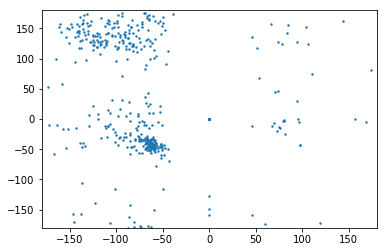

In [95]:
plt.scatter(beta[9], alpha[9], s=2)
plt.xlim((-180,180))
plt.ylim((-180,180))